In [17]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy import constants as c
import pandas as pd 
import sys 
import dask.dataframe as dd 
import time
import argparse
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.measure import regionprops, label
from skimage.feature import blob_dog
from casatasks import simanalyze,  simobserve, tclean, exportfits, simalma
from astropy.visualization import simple_norm

In [3]:
input_dir = "models2"
output_dir = "sims"
i = 1
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
filename = os.path.join(input_dir, "gauss_cube_" + str(i) + ".fits")

In [5]:

project = 'sim'
antennalist = "alma_cycle9_configuration_files/alma.cycle9.3.cfg"
simobserve(
    project=project, 
    skymodel=filename,
    inbright="0.001Jy/pix",
    indirection="J2000 03h59m59.96s -34d59m59.50s",
    incell="0.1arcsec",
    incenter="230GHz",
    inwidth="10MHz",
    setpointings=True,
    integration="10s",
    direction="J2000 03h59m59.96s -34d59m59.50s",
    mapsize=["10arcsec"],
    maptype="hexagonal",
    obsmode="int",
    antennalist=antennalist,
    totaltime="2400s",
    thermalnoise="tsys-atm",
    user_pwv=0.8,
    seed=42,
    graphics="none",
    verbose=False,
    overwrite=True)






0%....10....20....30....40....50....60....70....80....90....100%
....10....20....30....40....50....60....70....80....90....100%


In [9]:
simanalyze(
    project=project,
    image=True,
    vis=os.path.join(project, "sim.alma.cycle9.3.noisy.ms"),
    imsize=[360, 360],
    cell=["0.1 arcsec"],
    analyze=True,
    graphics="none",
    verbose=False,
    overwrite=True,
    
    
)


0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%
2022-06-07 17:08:50	WARN	simanalyze::ImageRegrid::regrid	You are regridding an image whose beam is not well sampled by the pixel size.  Total flux can be lost when regridding such images, especially when the new pixel size is larger than the old pixel size. It is recommended to check the total flux of your input and output image, and if necessary rebin the input to have smaller pixels.


In [15]:
tclean(
    vis=os.path.join(project, "sim.alma.cycle9.3.ms"),
    imagename=project+'/sim.alma.cycle9.3',
    imsize=[360, 360],
    cell=["0.1 arcsec"],
    phasecenter="",
    specmode="cube",
    niter=0,
    fastnoise=False,
    calcpsf=True
)
exportfits(imagename=project+'/sim.alma.cycle9.3.image', 
           fitsimage=output_dir +'/dirty_cube_{}.fits'.format(3))


0%....10....20....30....40....50....60....70....80....90....100%
2022-06-07 17:14:07	WARN	tclean::::casa	Warning! Non-zero values at the edge of the .pb image can cause unexpected aliasing effects! (found value 0.2603057026863098 at index [356, 179, 0, 0])

0%....10....20....30....40....50....60....70....80....90....100%
2022-06-07 17:14:28	WARN	task_tclean::SIImageStore::restore (file src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2247)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.


2022-06-07 17:18:10	WARN	simalma::::casa	saveinputs not available in casatasks, skipping saving simalma inputs
2022-06-07 17:18:15	WARN	simalma::simalma::casa	------------------------------------------------------------
2022-06-07 17:18:15	WARN	simalma::simalma::casa	Step 1: simulating 12m ALMA array
2022-06-07 17:18:15	WARN	simalma::simalma::casa	------------------------------------------------------------

0%....10....20....30....40....50....60....70....80....90....100%
....10....20....30....40....50....60....70....80....90....100%
2022-06-07 17:20:14	WARN	simalma::simalma::casa	  This step is optional, but useful to assess the result from just one configuration.
2022-06-07 17:20:14	WARN	simalma::simalma::casa	  WARNING: The example clean shown here uses no mask, may diverge, and almost certainly is not optimal.
2022-06-07 17:20:14	WARN	simalma::simalma::casa	  Users are HIGHLY recommended to use interactive clean masking (in simanalyze or directly in clean)
2022-06-07 17:20:14	WARN	

AssertionError: the imagename parameter must be a path that exists ('sim1/sim.alma.cycle5.3.noisy.image' does not exist)

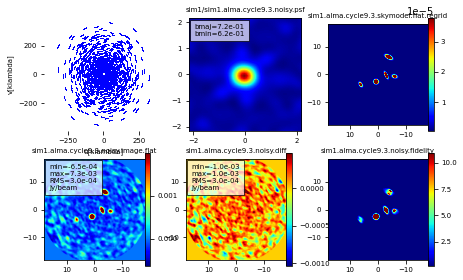

In [18]:
project = 'sim1'
simalma(
        project=project,
    dryrun=False,
    skymodel=filename,
    inbright="0.001Jy/pix",
    indirection="J2000 03h59m59.96s -34d59m59.50s",
    incell="0.1arcsec",
    incenter="230GHz",
    inwidth="10MHz",
    antennalist=antennalist,
    totaltime="2400s",
    mapsize=["10arcsec"],
    pwv=0.8,
    niter=0,
    imsize=[360, 360],
    overwrite=True,
    verbose=False
)
exportfits(imagename=project+'/sim1.alma.cycle5.3.noisy.image', 
           fitsimage=output_dir +'/dirty_cube_{}.fits'.format(4))
exportfits(imagename=project+'/sim1.alma.cycle5.3.skymodel', 
           fitsimage=output_dir +'/clean_cube_{}.fits'.format(4))

In [20]:
exportfits(imagename=project+'/sim1.alma.cycle9.3.noisy.image', 
           fitsimage=output_dir +'/dirty_cube_{}.fits'.format(4))
exportfits(imagename=project+'/sim1.alma.cycle9.3.skymodel', 
           fitsimage=output_dir +'/clean_cube_{}.fits'.format(4))

In [10]:
exportfits(imagename=project+'/sim.alma.cycle9.3.image', 
           fitsimage=output_dir +'/dirty_cube_{}.fits'.format(2))
exportfits(imagename=project+'/sim.alma.cycle9.3.skymodel', 
           fitsimage=output_dir +'/clean_cube_{}.fits'.format(2))

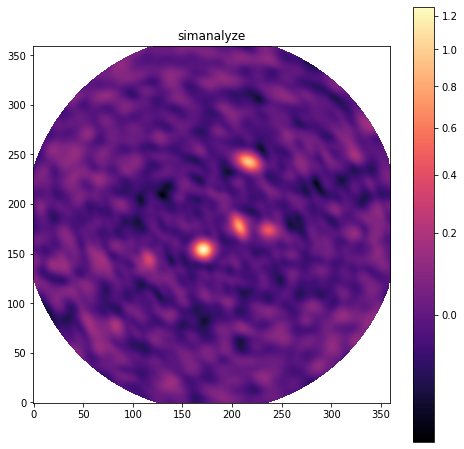

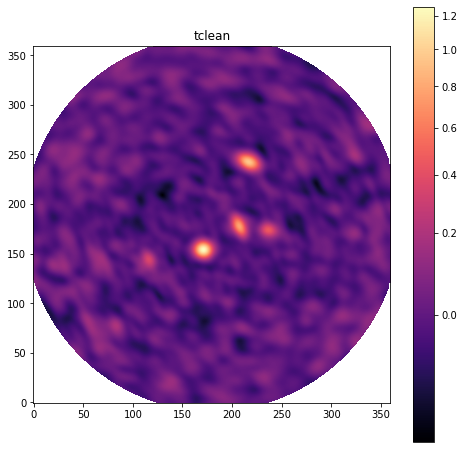

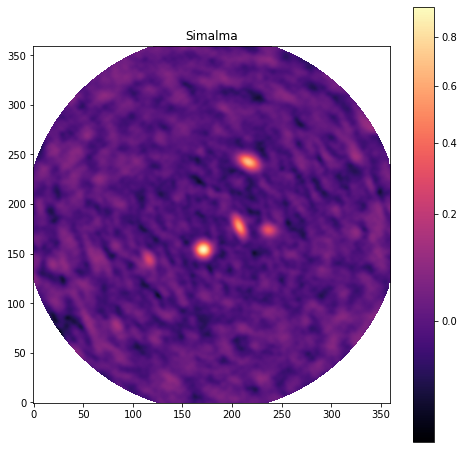

In [22]:

data = fits.getdata(os.path.join(output_dir, 'dirty_cube_2.fits'))[0]
image = np.sum(data, axis=0)
norm = simple_norm(image, 'sqrt')
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap="magma", origin="lower", norm=norm)
plt.colorbar()
plt.title('simanalyze')
plt.show()

data = fits.getdata(os.path.join(output_dir, 'dirty_cube_3.fits'))[0]
image = np.sum(data, axis=0)
norm = simple_norm(image, 'sqrt')
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap="magma", origin="lower", norm=norm)
plt.colorbar()
plt.title("tclean")
plt.show()

data = fits.getdata(os.path.join(output_dir, 'dirty_cube_4.fits'))[0]
image = np.sum(data, axis=0)
norm = simple_norm(image, 'sqrt')
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap="magma", origin="lower", norm=norm)
plt.colorbar()
plt.title("Simalma")
plt.show()

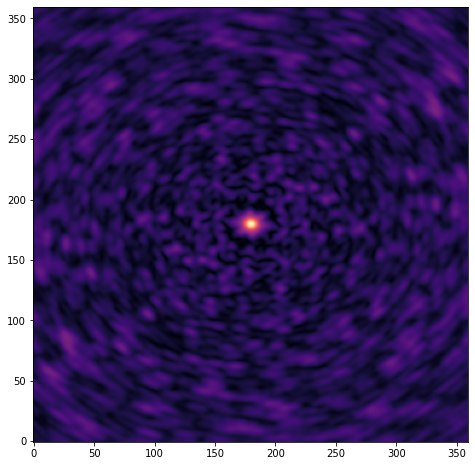

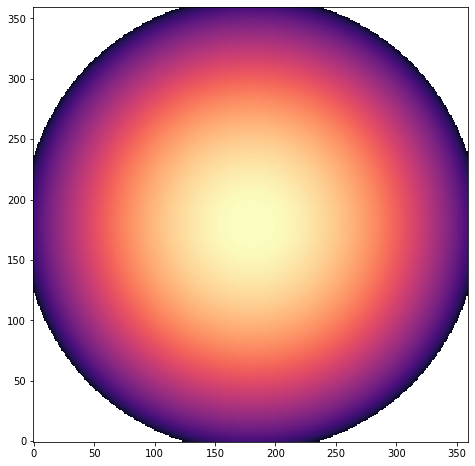

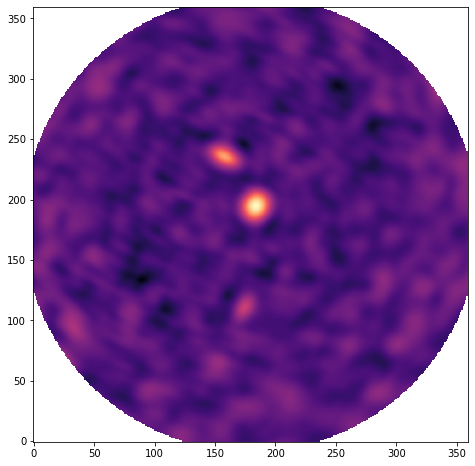

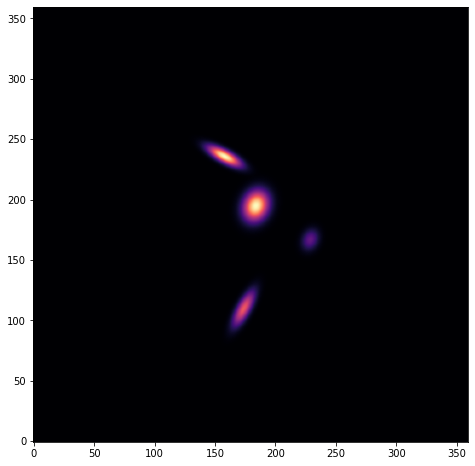

In [18]:
exportfits(imagename=project+'/sim.alma.cycle9.3.psf', 
           fitsimage=project+'/psf.fits')
exportfits(imagename=project+'/sim.alma.cycle9.3.pb', 
           fitsimage=project+'/pb.fits')
exportfits(imagename=project+'/sim.alma.cycle9.3.image', 
           fitsimage=project+'/dirty_cube.fits')
exportfits(imagename=project+'/sim.alma.cycle9.3.skymodel', 
           fitsimage=project+'/clean_cube.fits')

data = fits.getdata(os.path.join(project, 'psf.fits'))[0]
image = np.sum(data, axis=0)
norm = simple_norm(image, 'sqrt')
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap="magma", origin="lower", norm=norm)
plt.show()

data = fits.getdata(os.path.join(project, 'pb.fits'))[0]
image = np.sum(data, axis=0)
norm = simple_norm(image, 'sqrt')
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap="magma", origin="lower", norm=norm)
plt.show()

data = fits.getdata(os.path.join(project, 'dirty_cube.fits'))[0]
image = np.sum(data, axis=0)
norm = simple_norm(image, 'sqrt')
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap="magma", origin="lower", norm=norm)
plt.show()

data = fits.getdata(os.path.join(project, 'clean_cube.fits'))[0]
image = np.sum(data, axis=0)
norm = simple_norm(image, 'sqrt')
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap="magma", origin="lower", norm=norm)
plt.show()

2022-06-07 16:42:08	WARN	simobserve::FITSCoordinateUtil::fromFITSHeader	The wcs function failures are too severe to continue ...
2022-06-07 16:42:08	WARN	simobserve::FITSImage::getImageAttributes (file casacore/images/Images/FITSImage.cc, line 726)	No proper coordinate system defined in FITS file. Using dummy linear system instead.

0%....10....20....30....40....50....60....70....80....90....100%
....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%

0%....10....20....30....40....50....60....70....80....90....100%
2022-06-07 16:44:41	WARN	simanalyze::ImageRegrid::regrid	You are regridding an image whose beam is not well sampled by the pixel size.  Total flux can be lost when regridding such images, especially when the new pixel size is larger than the old pixel size. It is recommended to check the total flux of your input and output image, and if necessary rebin the input to have smaller pixels.
2022-06-07 16:44

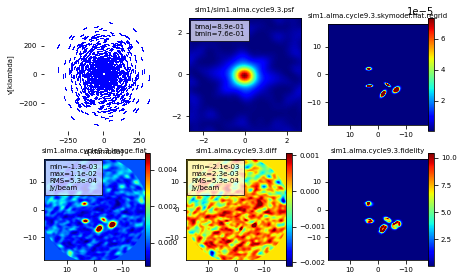

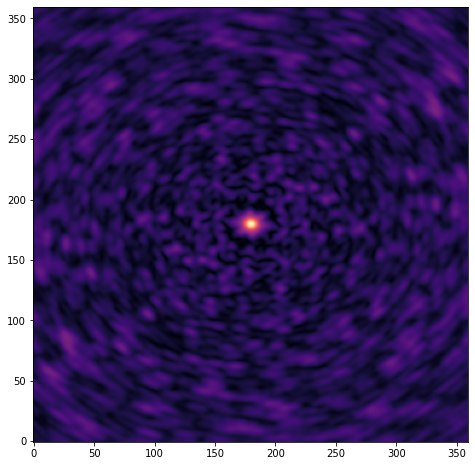

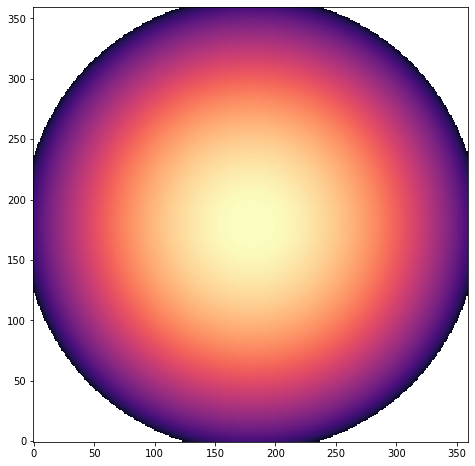

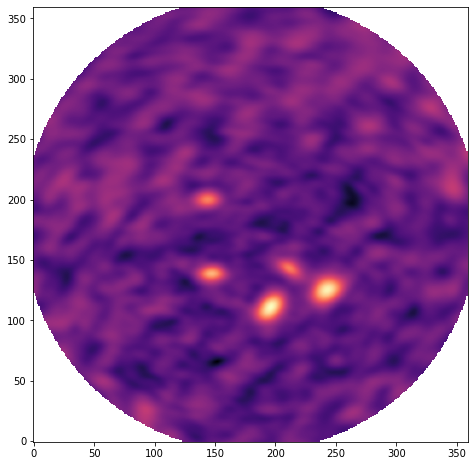

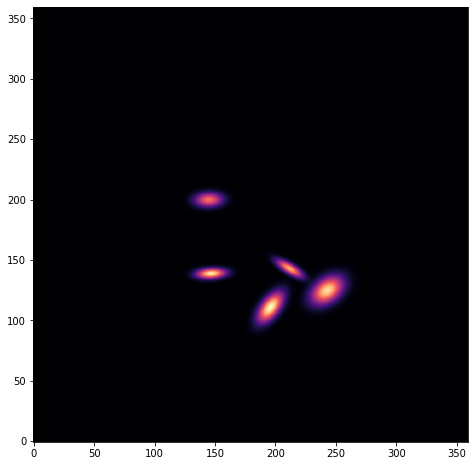

In [19]:
input_dir = "models2"
output_dir = "sims"
i = 1
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
filename = os.path.join(input_dir, "gauss_cube_" + str(i) + ".fits")
project = 'sim1'
antennalist = "alma_cycle9_configuration_files/alma.cycle9.3.cfg"
simobserve(
    project=project, 
    skymodel=filename,
    inbright="0.001Jy/pix",
    indirection="J2000 03h59m59.96s -34d59m59.50s",
    incell="0.1arcsec",
    incenter="230GHz",
    inwidth="10MHz",
    setpointings=True,
    integration="10s",
    direction="J2000 03h59m59.96s -34d59m59.50s",
    mapsize=["10arcsec"],
    maptype="hexagonal",
    obsmode="int",
    antennalist=antennalist,
    totaltime="2400s",
    thermalnoise="tsys-atm",
    user_pwv=0.8,
    seed=42,
    graphics="screen",
    verbose=True,
    overwrite=True)
simanalyze(
    project=project,
    image=True,
    vis=os.path.join(project, "sim1.alma.cycle9.3.ms"),
    imsize=[360, 360],
    cell=["0.1 arcsec"],
    analyze=True,
    graphics="screen",
    verbose=True,
    overwrite=True,
     
)
exportfits(imagename=project+'/sim1.alma.cycle9.3.psf', 
           fitsimage=project+'/psf.fits')
exportfits(imagename=project+'/sim1.alma.cycle9.3.pb', 
           fitsimage=project+'/pb.fits')
exportfits(imagename=project+'/sim1.alma.cycle9.3.image', 
           fitsimage=project+'/dirty_cube.fits')
exportfits(imagename=project+'/sim1.alma.cycle9.3.skymodel', 
           fitsimage=project+'/clean_cube.fits')

data = fits.getdata(os.path.join(project, 'psf.fits'))[0]
image = np.sum(data, axis=0)
norm = simple_norm(image, 'sqrt')
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap="magma", origin="lower", norm=norm)
plt.show()

data = fits.getdata(os.path.join(project, 'pb.fits'))[0]
image = np.sum(data, axis=0)
norm = simple_norm(image, 'sqrt')
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap="magma", origin="lower", norm=norm)
plt.show()

data = fits.getdata(os.path.join(project, 'dirty_cube.fits'))[0]
image = np.sum(data, axis=0)
norm = simple_norm(image, 'sqrt')
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap="magma", origin="lower", norm=norm)
plt.show()

data = fits.getdata(os.path.join(project, 'clean_cube.fits'))[0]
image = np.sum(data, axis=0)
norm = simple_norm(image, 'sqrt')
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap="magma", origin="lower", norm=norm)
plt.show()

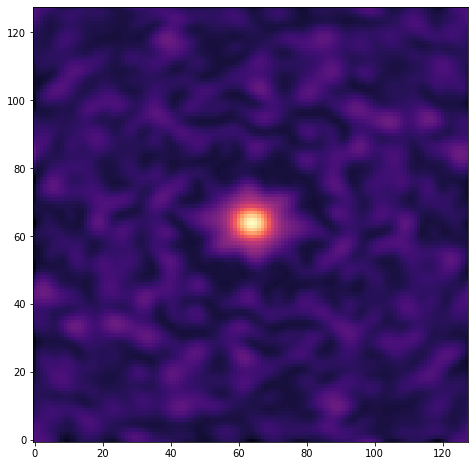

In [41]:
data = fits.getdata(os.path.join(project, 'psf.fits'))[0]
image = np.sum(data, axis=0)
norm = simple_norm(image, 'sqrt')
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap="magma", origin="lower", norm=norm)
plt.show()

data = fits.getdata(os.path.join(project, 'pb.fits'))[0]
image = np.sum(data, axis=0)
norm = simple_norm(image, 'sqrt')
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap="magma", origin="lower", norm=norm)
plt.show()


0%....10....20....30....40....50....60....70....80....90....100%
2022-06-07 14:51:14	WARN	tclean::::casa	Warning! Non-zero values at the edge of the .pb image can cause unexpected aliasing effects! (found value 0.2603057026863098 at index [356, 179, 0, 0])

0%....10....20....30....40....50....60....70....80....90....100%
2022-06-07 14:51:36	WARN	task_tclean::SIImageStore::restore (file src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2247)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.


<Figure size 576x576 with 0 Axes>

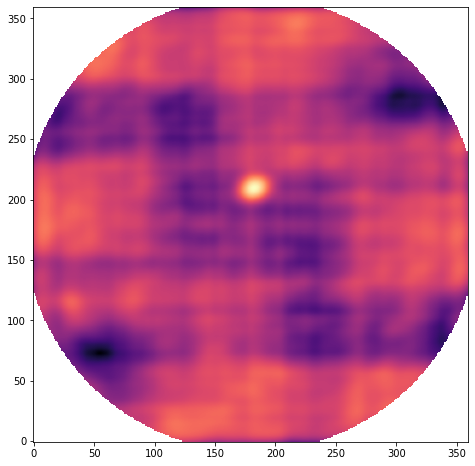

In [52]:
tclean(
    vis=os.path.join(project, "sim.alma.cycle9.3.ms"),
    imagename=os.path.join(project, "gauss_cube"),
    imsize=[360, 360],
    cell=["0.1 arcsec"],
    phasecenter="",
    specmode="cube",
    niter=0,
    fastnoise=False,
    calcpsf=True
)
exportfits(imagename=project+'/gauss_cube.image', 
           fitsimage=project+'/gauss_cube.fits')
data = fits.getdata(os.path.join(project, 'gauss_cube.fits'))[0]
data.shape
plt.figure(figsize=(8, 8))
image = np.sum(data, axis=0)
norm = simple_norm(image, 'sqrt')
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap="magma", origin="lower", norm=norm)
plt.show()

(128, 360, 360)


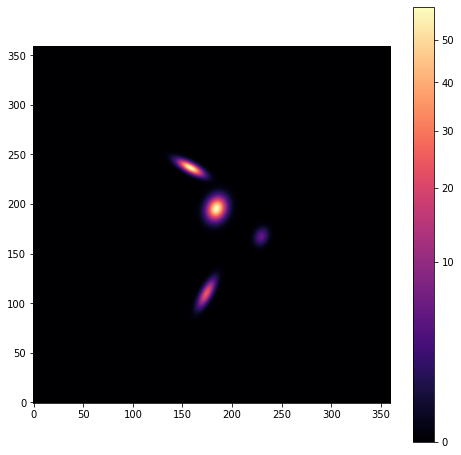

0.0 58.547466


In [10]:
data = fits.getdata(filename)
print(data.shape)
image = np.sum(data, axis=0)
norm = simple_norm(image, 'sqrt')
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap="magma", origin="lower", norm=norm)
plt.colorbar()
plt.show()

print(np.min(image), np.max(image))


    ID  amplitude      x      y  width_x  width_y  angle  line_peak  \
0  0.0       3.10  124.0  213.0     3.39     4.67  56.66       3.30   
1  0.0       2.94  150.0  220.0     2.91     3.21  67.17       2.66   

   line_fwhm      z  sp_idx  
0       4.06  80.61    0.75  
1       9.86  41.82   -0.83  


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


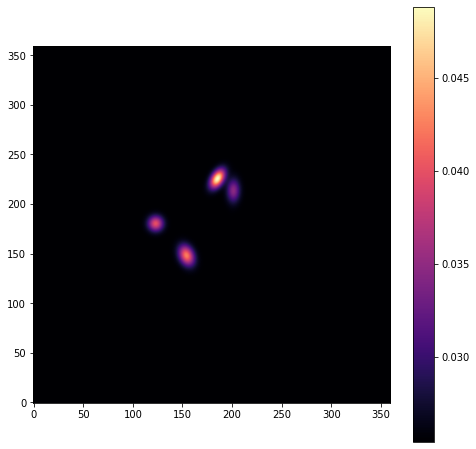

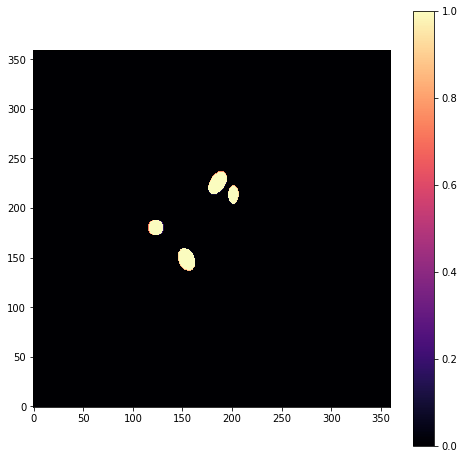

4


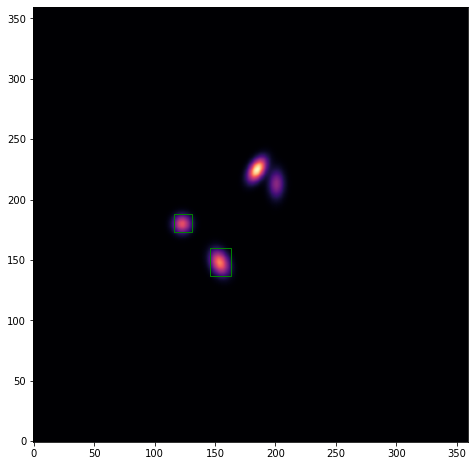

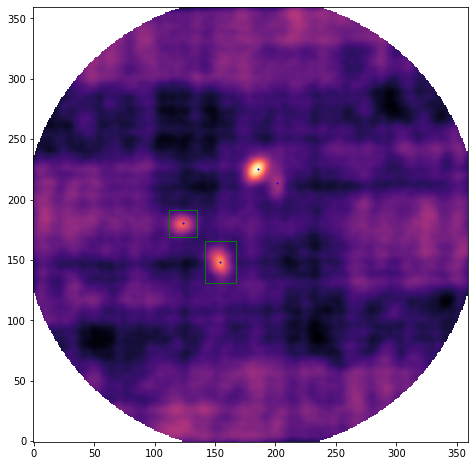

In [3]:
input_dir = "models"
output_dir = "sims"
catalogue_name = "params.csv"
input_dataframe = pd.read_csv(os.path.join(input_dir, catalogue_name))
i = 0
lines = input_dataframe.loc[input_dataframe.ID == i]
data, header = fits.getdata(os.path.join(output_dir, 'gauss_cube_sim_{}.dirty.fits'.format(i)), header=True)
data = data[0]
print(lines)
w = WCS(header).dropaxis(3).dropaxis(2)
xs, ys, wxs, wys, lfwhms, z = lines["x"].astype(int), lines["y"].astype(int), lines["width_x"].astype(int), lines["width_y"].astype(int), lines["line_fwhm"].astype(int), lines['z'].astype(int)
ids, amplitudes, angles, lpeaks, sp_idxs = lines["ID"].astype(int), lines["amplitude"].astype(float), lines["angle"].astype(float), lines["line_peak"].astype(float), lines["sp_idx"].astype(float)
pixel_coords = np.column_stack((xs, ys))
ras, decs = w.pixel_to_world(pixel_coords)
cdata = fits.getdata(os.path.join(output_dir, 'gauss_cube_sim_{}.skymodel.fits'.format(i)))[0]
tseg = np.sum(cdata, axis=0).copy()
plt.figure(figsize=(8, 8))
plt.imshow(tseg, origin="lower", cmap="magma")
plt.colorbar()
plt.show()
tseg[tseg >= 0.03] = 1
tseg = tseg.astype(int)
plt.figure(figsize=(8, 8))
plt.imshow(tseg, origin="lower", cmap="magma")
plt.colorbar()
plt.show()
props = regionprops(label(tseg, connectivity=2))
x0s, y0s, x1s, y1s = [], [], [], []
for prop in props:
    y0, x0, y1, x1 = prop.bbox
    x0s.append(x0)
    x1s.append(x1)
    y1s.append(y1)
    y0s.append(y0)
x0s = np.array(x0s)
x1s = np.array(x1s)
y0s = np.array(y0s)
y1s = np.array(y1s)
print(len(x0s))
widths = x1s - x0s
heights = y1s - y0s
x, y = x0s + 0.5 * (widths), y0s + 0.5 * (heights)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
ax.imshow(np.sum(cdata, axis=0), origin="lower", cmap="magma")
for k in range(len(x0s)):
    rect = patches.Rectangle(xy=(x0s[k], y0s[k]), 
                width=widths[k],
                height=heights[k],
                facecolor="none",
                edgecolor='green')
    ax.add_patch(rect)
plt.show()

factor = 1.5
x0s = x - 0.5 * (factor * widths)
x1s = x + 0.5 * (factor * widths)
y0s = y - 0.5 * (factor * heights)
y1s = y + 0.5 * (factor * heights)
widths = x1s - x0s
heights = y1s - y0s

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
ax.imshow(np.sum(data, axis=0), origin="lower", cmap="magma")
for k in range(len(xs)):
    rect = patches.Rectangle(xy=(x0s[k], y0s[k]), 
                width=widths[k],
                height=heights[k], 
                facecolor="none",
                edgecolor='green')
    ax.add_patch(rect)
plt.scatter(x, y, c="blue", s=1)
plt.show()


In [ ]:
spectra = np.array([
    np.sum(data[:, y0s[j]: y1s[j], x0s[j]:x1s[j]], 
    axis=(1, 2)) for j in range(len(lines))
])
for spectrum in spectra:
    plt.figure(figsize=(8, 4))
    plt.plot(spectrum)
    plt.show()